# **Hippocampal gene expression maps**

## **Overview**
In this notebook, we will generate transcriptomic maps of the hippocampus from the Allen Human Brain Atlas and derive spatial gradients of gene expresion.

**Set up**

In [1]:
# Import libraries
import abagen
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygeodesic.geodesic as geodesic
from hippunfold_toolbox.utils import density_interp

from hippunfold_toolbox import plotting
from abagen.utils import flatten_dict

**1 - Derive preprocessed gene expression samples** 

In [2]:
# Define paths and files
ahba_dir = '/data/mica3/AHBA/'
rawdata_dir = ahba_dir + 'rawdata/'
hippunfold_dir = ahba_dir + 'derivatives/hippunfold_v1.4.1/hippunfold/'

files = {
    
    '12876': { 'microarray': rawdata_dir + 'sub-1009/microarray/MicroarrayExpression.csv',
               'ontology': rawdata_dir + 'sub-1009/microarray/Ontology.csv',
               'pacall': rawdata_dir + 'sub-1009/microarray/PACall.csv',
               'probes': rawdata_dir + 'sub-1009/microarray/Probes.csv', 
               'annotation': rawdata_dir + 'sub-1009/microarray/SampleAnnot.csv'},
    
    '14380': { 'microarray': rawdata_dir + 'sub-1012/microarray/MicroarrayExpression.csv',
               'ontology': rawdata_dir + 'sub-1012/microarray/Ontology.csv',
               'pacall': rawdata_dir + 'sub-1012/microarray/PACall.csv',
               'probes': rawdata_dir + 'sub-1012/microarray/Probes.csv', 
               'annotation': rawdata_dir + 'sub-1012/microarray/SampleAnnot.csv'},
    
    '15496': { 'microarray': rawdata_dir + 'sub-1015/microarray/MicroarrayExpression.csv',
               'ontology': rawdata_dir + 'rawdata/sub-1015/microarray/Ontology.csv',
               'pacall': rawdata_dir + 'sub-1015/microarray/PACall.csv',
               'probes': rawdata_dir + 'sub-1015/microarray/Probes.csv', 
               'annotation': rawdata_dir + 'sub-1015/microarray/SampleAnnot.csv'},
    
    '15697': { 'microarray': rawdata_dir + 'sub-1016/microarray/MicroarrayExpression.csv',
               'ontology': rawdata_dir + 'sub-1016/microarray/Ontology.csv',
               'pacall': rawdata_dir + 'sub-1016/microarray/PACall.csv',
               'probes': rawdata_dir + 'sub-1016/microarray/Probes.csv', 
               'annotation': rawdata_dir + 'sub-1016/microarray/SampleAnnot.csv'},
    
    '9861': { 'microarray': rawdata_dir + 'sub-2001/microarray/MicroarrayExpression.csv',
              'ontology': rawdata_dir + 'sub-2001/microarray/Ontology.csv',
              'pacall': rawdata_dir + 'sub-2001/microarray/PACall.csv',
              'probes': rawdata_dir + 'sub-2001/microarray/Probes.csv', 
              'annotation': rawdata_dir + 'sub-2001/microarray/SampleAnnot.csv'},
    
    '10021': { 'microarray': rawdata_dir + 'sub-2002/microarray/MicroarrayExpression.csv',
               'ontology': rawdata_dir + 'sub-2002/microarray/Ontology.csv',
               'pacall': rawdata_dir + 'sub-2002/microarray/PACall.csv',
               'probes': rawdata_dir + 'sub-2002/microarray/Probes.csv', 
               'annotation': rawdata_dir + 'sub-2002/microarray/SampleAnnot.csv'}
    
}

In [3]:
# Get "native" MRI coordinates and voxels
for donor, data in files.items():
    annot = pd.read_csv(data['annotation'])
    files[donor]['annotation'] = annot

cols = ['well_id', 'mni_x', 'mni_y', 'mni_z']
coords = np.asarray(pd.concat(flatten_dict(files, 'annotation'))[cols])
well_id, coords = np.asarray(coords[:, 0], 'int'), coords[:, 1:]
coords = pd.DataFrame(coords, columns=['x', 'y', 'z'], index=well_id)

cols = ['well_id', 'mri_voxel_x', 'mri_voxel_y', 'mri_voxel_z']
voxels = np.asarray(pd.concat(flatten_dict(files, 'annotation'))[cols])
well_id, voxels = np.asarray(voxels[:, 0], 'int'), voxels[:, 1:]
voxels = pd.DataFrame(voxels, columns=['x', 'y', 'z'], index=well_id)

In [4]:
# Generate atlas image where each voxel with sample has value of 1
affine = np.eye(4)
affine[:-1, -1] = -1 * np.floor(np.max(np.abs(coords), axis=0))
img = np.ones(np.asarray(-2 * affine[:-1, -1], dtype=int))
mask = nib.Nifti1Image(img, affine=affine)

In [6]:
# Get all expression data and drop sample coordinates that weren't in atlas
microarray = abagen.get_expression_data(data_dir='/data/mica3/AHBA/microarray/',
                                        donors='all', 
                                        atlas=mask, 
                                        atlas_info=None,
                                        region_agg=None,
                                        return_donors=True,
                                        norm_matched=False, 
                                        probe_selection='rnaseq')

microarray = {
    donor: micro.drop(index=[0], level='label', errors='ignore')
                .droplevel('label')
    for donor, micro in microarray.items()
}

coords = {
    donor: coords.loc[micro.index]
    for donor, micro in microarray.items()
}

voxels = {
    donor: voxels.loc[micro.index]
    for donor, micro in microarray.items()
}

/host/yeatman/local_raid/ango/anaconda3/envs/py3/lib/python3.9/site-packages/abagen/probes_.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  reannotated.loc[:, 'entrez_id'] = reannotated['entrez_id'].astype('int')



Dataset created in /home/bic/ango/abagen-data/rnaseq



Downloaded 23127642 of 23127642 bytes (100.0%,    0.0s remaining) ...done. (7 seconds, 0 min)
Extracting data from /home/bic/ango/abagen-data/rnaseq/ad34df880e08700364530a3299829aa4/rnaseq_donor9861/donor9861.zip..... done.


Downloaded 23525019 of 23525019 bytes (100.0%,    0.0s remaining) ...done. (7 seconds, 0 min)
Extracting data from /home/bic/ango/abagen-data/rnaseq/ad34df880e08700364530a3299829aa4/rnaseq_donor10021/donor10021.zip..... done.


**2 - Extract samples that are within hippocampal gray matter**

In [7]:
donor_list = {'12876':'sub-1009',
              '14380':'sub-1012',
              '15496':'sub-1015', 
              '15697':'sub-1016', 
              '9861':'sub-2001',
              '10021':'sub-2002'
             }

In [12]:
# Get samples that are in one of the subfields
hipp_microarray = {}
hipp_voxels = {}
hipp_coords = {}
for donor, micro in microarray.items():
    
    sub = donor_list[donor]
    
    hipp_l_subfields = nib.load(hippunfold_dir + sub + '/anat/' + sub + '_hemi-L_space-T1w_desc-subfields_atlas-multihist7_dseg.nii.gz').get_fdata()
    hipp_r_subfields = nib.load(hippunfold_dir + sub + '/anat/' + sub + '_hemi-R_space-T1w_desc-subfields_atlas-multihist7_dseg.nii.gz').get_fdata()

    hipp_subfields = hipp_l_subfields + hipp_r_subfields
    
    x = voxels[donor]['x']
    y = voxels[donor]['y']
    z = voxels[donor]['z']
    
    hipp_microarray |= {donor: micro[np.isin(hipp_subfields[x,y,z], [i for i in range(1,6)])]}
    hipp_voxels |= {donor: voxels[donor][np.isin(hipp_subfields[x,y,z], [i for i in range(1,6)])]}

In [13]:
# Save hippocampal gene expression
np.save('/data/mica3/AHBA/scripts/hipp_microarray.npy', hipp_microarray) 
np.save('/data/mica3/AHBA/scripts/hipp_voxels.npy', hipp_voxels) 

**3 - Project samples to the hippocampal surface**

In [5]:
# Load data
hipp_microarray = np.load('/data/mica3/AHBA/scripts/hipp_microarray.npy', allow_pickle=True)
hipp_voxels = np.load('/data/mica3/AHBA/scripts/hipp_voxels.npy', allow_pickle=True)

hipp_microarray = dict(enumerate(hipp_microarray.flatten(), 1))[1]
hipp_voxels = dict(enumerate(hipp_voxels.flatten(), 1))[1]

In [14]:
# Set distance threshold (mm)
dist_threshold = 2.5

In [15]:
# Left hemisphere
hipp_data_lh = {}
coord = {}
for d in donor_list.keys():
    n_samples = hipp_microarray[d].shape[0]
    vertices = np.ones([419, 3]) * np.nan
    
    hipp_exp = np.zeros([419, n_samples, 13561])
    hipp_sample = np.zeros([419, n_samples])
    hipp_exp_count = np.zeros([419])
    
    surf = nib.load(hippunfold_dir + donor_list[d] + '/surf/' + donor_list[d] + '_hemi-L_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
    affine = nib.load(hippunfold_dir + donor_list[d] + '/anat/' + donor_list[d] + '_hemi-L_space-T1w_desc-subfields_atlas-multihist7_dseg.nii.gz').affine
    vertices[:,:] = surf.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
    
    # Convert voxels to vertices
    c = np.array(hipp_voxels[d])
    c = np.concatenate((c,np.ones((c.shape[0],1))),axis=1)
    c = affine @ c.T
    c = c[:3,:].T
    
    dist_list = np.zeros([419, n_samples]) * np.nan
    for i in range(n_samples):
        coord_x = c[i,0]
        coord_y = c[i,1]
        coord_z = c[i,2]
        
        for v in range(vertices.shape[0]):

            dist = np.linalg.norm(np.array([coord_x, coord_y, coord_z]) - vertices[v, :])
            if dist <= dist_threshold:
                hipp_exp[v, i, :] = np.array(hipp_microarray[d].iloc[i])
                hipp_sample[v,i] = 1
                hipp_exp_count[v] += 1
    
    hipp_data_lh |= {d: {'expression': hipp_exp, 'sample_location': hipp_sample,'count': hipp_exp_count} }

In [16]:
# Right hemisphere
hipp_data_rh = {}

for d in donor_list.keys():
    n_samples = hipp_microarray[d].shape[0]
    vertices = np.ones([419, 3]) * np.nan
    
    hipp_exp = np.zeros([419, n_samples, 13561])
    hipp_sample = np.zeros([419, n_samples])
    hipp_exp_count = np.zeros([419])
    
    surf = nib.load(hippunfold_dir + donor_list[d] + '/surf/' + donor_list[d] + '_hemi-R_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
    affine = nib.load(hippunfold_dir + donor_list[d] + '/anat/' + donor_list[d] + '_hemi-R_space-T1w_desc-subfields_atlas-multihist7_dseg.nii.gz').affine
    vertices[:,:] = surf.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
    
    # Convert voxels to vertices
    c = np.array(hipp_voxels[d])
    c = np.concatenate((c,np.ones((c.shape[0],1))),axis=1)
    c = affine @ c.T
    c = c[:3,:].T
        
    for i in range(n_samples):
        coord_x = c[i,0]
        coord_y = c[i,1]
        coord_z = c[i,2]
        
        for v in range(vertices.shape[0]):

            dist = np.linalg.norm(np.array([coord_x, coord_y, coord_z]) - vertices[v, :])
            if dist <= dist_threshold:
                hipp_exp[v, i, :] = np.array(hipp_microarray[d].iloc[i])
                hipp_sample[v,i] = 1
                hipp_exp_count[v] += 1
    
    hipp_data_rh |= {d: {'expression': hipp_exp, 'sample_location': hipp_sample,'count': hipp_exp_count} }

In [18]:
# Plot sample location of an individual

# Donor list:
# '12876' : 'sub-1009'
# '14380' : 'sub-1012'
# '15496' : 'sub-1015' 
# '15697' : 'sub-1016' 
# '9861'  : 'sub-2001'
# '10021' : 'sub-2002'
d = '12876'
print(d, donor_list[d])

for i in range(hipp_data_lh[d]['sample_location'].shape[1]):
    location = np.zeros(7262) * np.nan
    x_ = np.copy(hipp_data_lh[d]['sample_location'][:,i])
    x_ = density_interp('2mm', '0p5mm', x_, 'hipp', method='nearest')[0]
    location[x_== 1] = 1
    x_[x_== 0] = np.nan
    plotting.surfplot_canonical_foldunfold(x_, hemis=['L'], labels=['hipp'], cmap='viridis', color_range=(0,1), nan_color=(0.7, 0.7, 0.7, 1), den='0p5mm', embed_nb=True, screenshot=False, filename=f'/host/yeatman/local_raid/ango/HippoMaps_Gene/probes_{i}.png')

12876 sub-1009


/host/yeatman/local_raid/ango/anaconda3/envs/py3/lib/python3.9/site-packages/brainspace-0.1.4-py3.9.egg/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


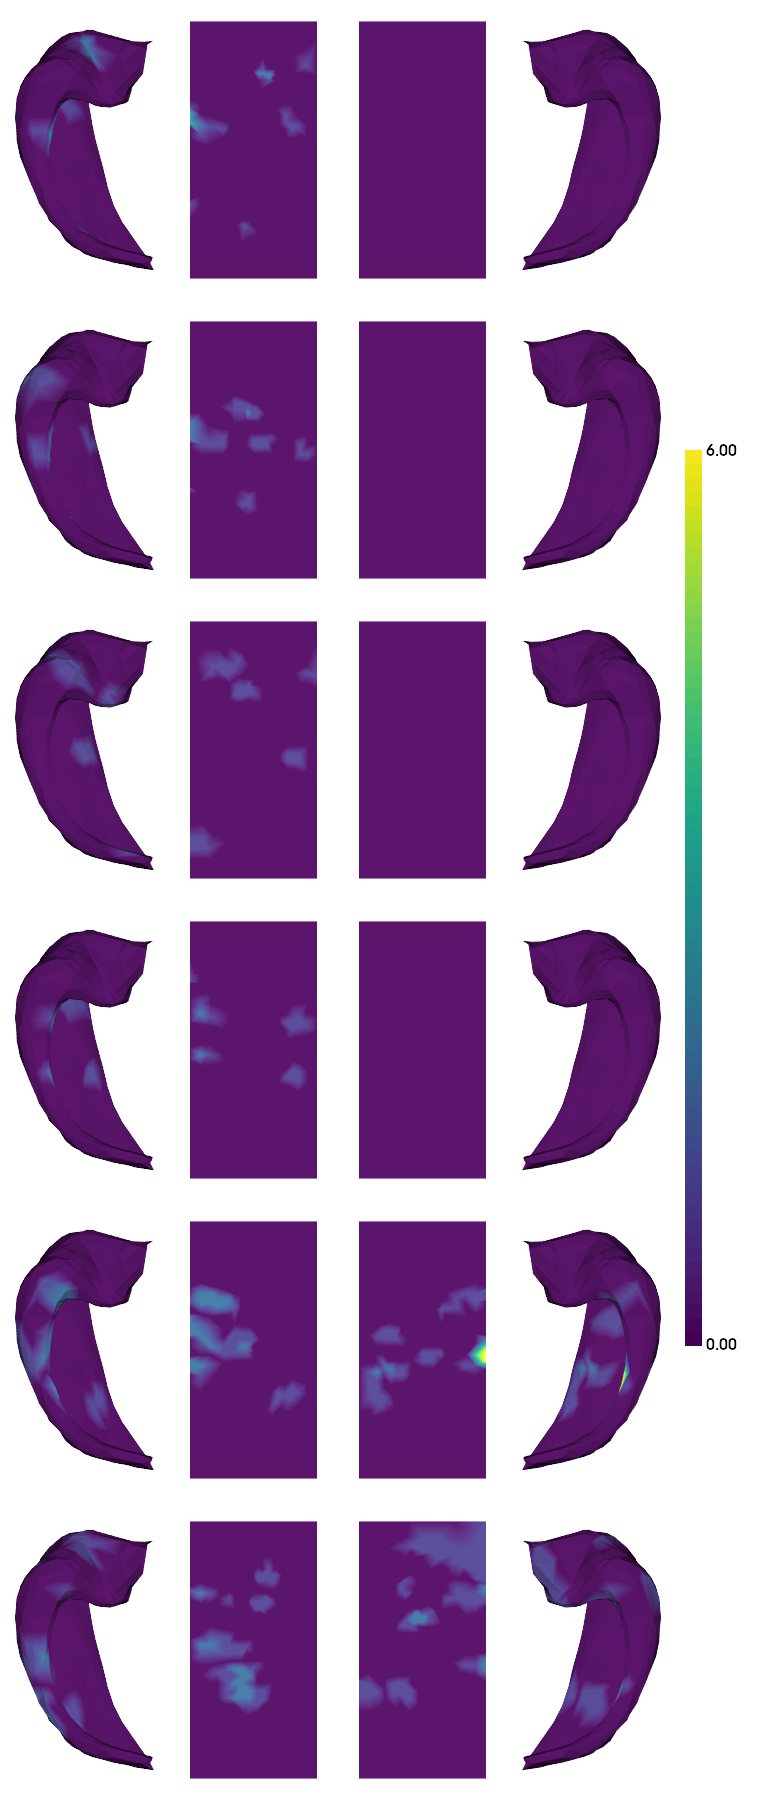

In [20]:
# Plot count 
x = np.zeros([419, 2, 6])
x[:,0,:] = np.array([d['count'] for d in hipp_data_lh.values()]).T 
x[:,1,:] = np.array([d['count'] for d in hipp_data_rh.values()]).T 
plotting.surfplot_canonical_foldunfold(x, hemis=['L', 'R'], labels=['hipp'], den='2mm', color_bar='right', share='both', embed_nb=True)

**4 - Interpolate and smooth gene expression data (takes a while to run)**

In [21]:
# Left hemisphere
for d in donor_list.keys():
    
    print(d)
    
    n_samples = hipp_microarray[d].shape[0]
    n_genes = hipp_microarray[d].shape[1]
    
    d_sample = hipp_data_lh[d]['sample_location']
    d_expression = hipp_data_lh[d]['expression']
    
    weight = np.ones([419, n_samples]) * np.nan 
    interp = np.zeros([419, n_genes])   
    
    # Compute geodesic distance between all vertice and the sample location
    for s in range(n_samples):       
        
        mask = np.where(d_sample[:,s] == 1)[0]
        
        # If probe is on the right hemisphere, then assign weight 0 to all vertices
        if len(mask) == 0:
            weight[:,s] = 0
            continue
            
        surf = nib.load(hippunfold_dir + donor_list[d] + '/surf/' + donor_list[d] + '_hemi-L_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
        v = surf.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
        f = surf.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
    
        geoalg = geodesic.PyGeodesicAlgorithmExact(v, f)
        dist,_ = geoalg.geodesicDistances(mask, None)
        weight[:,s] = 1 - dist/np.max(dist)
    
    # Interpolate/extrapolate gene expression data
    total_weight = np.nansum(weight, axis=1)
    for v in range(419):
        for s in range(n_samples):
            w = weight[v,s] / total_weight[v]
            if w > 0:
                for g in range(n_genes):
                    exp = np.nanmean(d_expression[:, s, g])
                    if exp > 0:
                        interp[v,g] += w * exp
    
    hipp_data_lh[d]['interp'] = interp 

12876
14380
15496
15697
9861
10021


In [22]:
# Right hemisphere
for d in donor_list.keys():
    
    print(d)
    
    n_samples = hipp_microarray[d].shape[0]
    n_genes = hipp_microarray[d].shape[1]
    
    d_sample = hipp_data_rh[d]['sample_location']
    d_expression = hipp_data_rh[d]['expression']
    
    weight = np.ones([419, n_samples]) * np.nan 
    interp = np.zeros([419, n_genes])   
    
    # Compute geodesic distance between all vertice and the sample location
    for s in range(n_samples):       
        
        mask = np.where(d_sample[:,s] == 1)[0]
        
        # If probe is on the left hemisphere, then assign weight 0 to all vertices
        if len(mask) == 0:
            weight[:,s] = 0
            continue
            
        surf = nib.load(hippunfold_dir + donor_list[d] + '/surf/' + donor_list[d] + '_hemi-R_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
        v = surf.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
        f = surf.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
    
        geoalg = geodesic.PyGeodesicAlgorithmExact(v, f)
        dist,_ = geoalg.geodesicDistances(mask, None)
        weight[:,s] = 1 - dist/np.max(dist)
    
    # Interpolate/extrapolate gene expression data
    total_weight = np.nansum(weight, axis=1)
    for v in range(419):
        for s in range(n_samples):
            w = weight[v,s] / total_weight[v]
            if w > 0:
                for g in range(n_genes):
                    exp = np.nanmean(d_expression[:, s, g])
                    if exp > 0:
                        interp[v,g] += w * exp
    
    hipp_data_rh[d]['interp'] = interp 

12876
14380
15496
15697
9861


/tmp/ipykernel_14059/3848945158.py:37: RuntimeWarning: invalid value encountered in double_scalars
  w = weight[v,s] / total_weight[v]


10021


In [26]:
# Save interpolated gene expression
np.save('/data/mica3/AHBA/scripts/hipp_data_lh.npy', hipp_data_lh) 
np.save('/data/mica3/AHBA/scripts/hipp_data_rh.npy', hipp_data_rh) 

**5 - Generate atlas of gene expression data (mean across donors)**

In [45]:
# Load data
hipp_data_lh = np.load('/data/mica3/AHBA/scripts/hipp_data_lh.npy', allow_pickle=True)
hipp_data_rh = np.load('/data/mica3/AHBA/scripts/hipp_data_rh.npy', allow_pickle=True)

hipp_data_lh = dict(enumerate(hipp_data_lh.flatten(), 1))[1]
hipp_data_rh = dict(enumerate(hipp_data_rh.flatten(), 1))[1]

In [27]:
# Left hippocampus
hipp_lh_expression = np.mean(np.array([d['interp'] for d in hipp_data_lh.values()]), axis=0)

# Right hippocampus
hipp_rh_expression = np.mean(np.array([d['interp'] for d in hipp_data_rh.values()]), axis=0)

In [28]:
# Save averaged gene expression maps as a csv
gene_list = list(hipp_microarray['9861'].columns) # Same for every donor

df_hipp_lh_expression = pd.DataFrame(data = hipp_lh_expression, columns = gene_list) 
df_hipp_rh_expression = pd.DataFrame(data = hipp_rh_expression, columns = gene_list) 

df_hipp_lh_expression.to_csv('/data/mica3/AHBA/scripts/hipp_lh_expression.csv')
df_hipp_rh_expression.to_csv('/data/mica3/AHBA/scripts/hipp_rh_expression.csv')